In [1]:
import nolds
import numpy as np
import scipy as sp
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import functions as fun
import importlib as imp
import plotly.io as pio
import statsmodels.api as sm
import plotly.graph_objects as go
import pymultifracs.mfa as mfa
from pymultifracs.utils import build_q_log

# Imports for seismic data check
from obspy import read
from obspy.clients.fdsn.client import Client
from obspy.core.utcdatetime import UTCDateTime

# Import for solar activity data check
from cdasws import CdasWs
from cdasws.datarepresentation import DataRepresentation as dr
cdas = CdasWs()

import warnings
warnings.filterwarnings("ignore")
pio.templates.default = "plotly_dark"

# Parameters that are used in the selection
from configparser import ConfigParser
config = ConfigParser()
config.read('config.cfg')
window = config.get('params', 'window')
tail = int(config.get('params', 'tail'))
window_metrics = int(config.get('params', 'window_metrics'))
distance = int(config.get('params', 'distance'))

In [ ]:
imp.reload(fun)

window - Parameter for the critical transition definition

window_metrics - Length of the sliding window for the calculation of metrics

distance - Length of the time series to use for the sliding metrics calculation

### Data Import

In [76]:
# Load a list of tickers from Russel 3000 to download
tickers = pd.read_csv('Data/IWV_holdings.csv', skiprows = 9)
tickers['Len'] = tickers['Ticker'].apply(lambda x: len(x))
tickers = tickers[(tickers['Len'] < 5) & ~(tickers['Ticker'].isin(['-', '\xa0'])) & ~(tickers['Ticker'].isna())]['Ticker']
tickers

0       MSFT
1       AAPL
2       NVDA
3       AMZN
4       META
        ... 
2693    CMAX
2694     EVA
2696    GTXI
2697    CANO
2702    ESH4
Name: Ticker, Length: 2666, dtype: object

In [77]:
# Loading data from Yahoo Finance
history = yf.download(tickers = list(tickers.values), period = "2y", interval = "1h", group_by = 'ticker', auto_adjust = True, progress = True, threads = True)
history.to_parquet('C:/Users/user/Downloads/imported_1h.parquet')

[*********************100%***********************]  2665 of 2665 completed

15 Failed downloads:
- HEIA: No data found, symbol may be delisted
- LGFA: No data found, symbol may be delisted
- BFB: No data found, symbol may be delisted
- ADRO: No data found, symbol may be delisted
- BRKB: No data found, symbol may be delisted
- FCFS: No data found for this date range, symbol may be delisted
- LGFB: No data found, symbol may be delisted
- ESH4: No data found, symbol may be delisted
- GEFB: No data found, symbol may be delisted
- MOGA: No data found, symbol may be delisted
- LENB: No data found, symbol may be delisted
- JBT: No data found for this date range, symbol may be delisted
- GTXI: No data found, symbol may be delisted
- ARD: No data found for this date range, symbol may be delisted
- BFA: No data found, symbol may be delisted


### Choice parameters selection

In [110]:
# Loading some of the datasets from the previous papers and calculating parameters to define critical transition
test = pd.read_csv('C:/Users/user/OneDrive/P&D/Диплом Б/Диплом/TSLA.csv')['Volume'].to_frame()
test['MA' + window] = test['Volume'].rolling(int(window)).mean()
test['Dynamics'] = test['MA' + window] / test['MA' + window].shift(10)
test['Rise'] = (test['Dynamics'] > 1.2)
test

,Volume,MA200,Dynamics,Rise
0,93831500,NaN,NaN,False
1,85935500,NaN,NaN,False
2,41094000,NaN,NaN,False
3,25699000,NaN,NaN,False
4,34334500,NaN,NaN,False
...,...,...,...,...
3038,21357800,27910389.5,1.016810,False
3039,22273600,27925778.5,1.014163,False
3040,29370000,27988935.5,1.014379,False
3041,28241000,28059139.0,1.017271,False


In [111]:
# Visualizing time series and a moving average
fig = go.Figure()
fig.add_trace(go.Scatter(y = test['Volume'], mode = 'lines', name = 'Volume'))
fig.add_trace(go.Scatter(y = test['MA' + window], mode = 'lines', name = 'MA' + window))
fig.add_vline(x = test[test['Rise']].head(1).index[0])
fig.show()

### Data Selection

#### Calculation of the dynamics and definition of the transition with MA

In [13]:
# Reloading imported financial data
data = pd.read_parquet('C:/Users/user/Downloads/imported_1h.parquet')
data.dropna(axis = 1, how = 'all', inplace = True)
data.replace(0, np.nan, inplace = True)

# Getting a list of available tickers
active_tickers = []
for i in range(len(data.columns)):
    active_tickers.append(data.columns[i][0])
active_tickers = set(active_tickers)

# Params for calculating critical transitions
ma = 1.3
mv = 1.05

# Calculating critical transitions in the time series
data_final = pd.DataFrame(data.index).set_index(0)
data_final.index.name = None
for ticker in tqdm(active_tickers):
    data_ticker = data[(ticker, 'Volume')].to_frame().dropna()
    data_ticker[(ticker, 'MA' + window)] = data_ticker[(ticker, 'Volume')].rolling(int(window)).mean()
    data_ticker[(ticker, 'MV' + window)] = data_ticker[(ticker, 'Volume')].rolling(int(window)).var()
    data_ticker[(ticker, 'Dynamics MA')] = data_ticker[(ticker, 'MA' + window)] / data_ticker[(ticker, 'MA' + window)].shift(5)
    data_ticker[(ticker, 'Dynamics MV')] = data_ticker[(ticker, 'MV' + window)] / data_ticker[(ticker, 'MV' + window)].shift(5)
    data_ticker[(ticker, 'Rise')] = (data_ticker[(ticker, 'Dynamics MA')] >= ma) & (data_ticker[(ticker, 'Dynamics MV')] >= mv)
    data_final = data_final.join(data_ticker)
data_final

100%|██████████| 2650/2650 [11:54<00:00,  3.71it/s]


,"(NWN, Volume)","(NWN, MA100)","(NWN, MV100)","(NWN, Dynamics MA)","(NWN, Dynamics MV)","(NWN, Rise)","(XEL, Volume)","(XEL, MA100)","(XEL, MV100)","(XEL, Dynamics MA)",...,"(FDP, MV100)","(FDP, Dynamics MA)","(FDP, Dynamics MV)","(FDP, Rise)","(GMS, Volume)","(GMS, MA100)","(GMS, MV100)","(GMS, Dynamics MA)","(GMS, Dynamics MV)","(GMS, Rise)"
2022-02-07 09:30:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,555499.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,49626.0,NaN,NaN,NaN,NaN,False
2022-02-07 10:30:00-05:00,8128.0,NaN,NaN,NaN,NaN,False,178174.0,NaN,NaN,NaN,...,NaN,NaN,NaN,False,24604.0,NaN,NaN,NaN,NaN,False
2022-02-07 11:30:00-05:00,5259.0,NaN,NaN,NaN,NaN,False,177207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,False,30190.0,NaN,NaN,NaN,NaN,False
2022-02-07 12:30:00-05:00,6784.0,NaN,NaN,NaN,NaN,False,133478.0,NaN,NaN,NaN,...,NaN,NaN,NaN,False,18512.0,NaN,NaN,NaN,NaN,False
2022-02-07 13:30:00-05:00,10747.0,NaN,NaN,NaN,NaN,False,137375.0,NaN,NaN,NaN,...,NaN,NaN,NaN,False,18963.0,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05 11:30:00-05:00,20582.0,26705.70,3.764889e+08,1.033083,1.089241,False,161109.0,482555.16,4.574638e+10,1.002058,...,2.823999e+08,1.026409,1.085036,False,12547.0,46888.67,2.062065e+09,1.018036,0.983706,False
2024-02-05 12:30:00-05:00,24102.0,26766.56,3.757909e+08,1.010375,1.018571,False,161868.0,480153.47,4.671386e+10,0.995252,...,2.825338e+08,1.001457,1.073554,False,11813.0,46729.76,2.070749e+09,1.007660,0.994389,False
2024-02-05 13:30:00-05:00,21104.0,26783.08,3.755741e+08,0.996949,1.002755,False,155596.0,478080.23,4.763471e+10,0.979381,...,2.818443e+08,0.974703,0.996625,False,12187.0,46710.51,2.072054e+09,0.998560,1.002465,False
2024-02-05 14:30:00-05:00,30107.0,26938.43,3.741552e+08,0.997320,0.999580,False,267201.0,477995.34,4.767014e+10,0.976447,...,2.818730e+08,0.969314,0.995437,False,17637.0,46754.88,2.069248e+09,0.997363,1.004073,False


In [14]:
# Getting a list of available tickers
pos = 0
ticks = []
active_tickers = []
for i in range(len(data_final.columns)):
    active_tickers.append(data_final.columns[i][0])
active_tickers = set(active_tickers)

# Selecting time series that have an adequate number of critical transitions
data_selected = pd.DataFrame(data_final.index).set_index(0)
data_selected.index.name = None
for ticker in tqdm(active_tickers):
    num_ma = len(data_final[(ticker, 'MA' + window)].dropna())
    if num_ma > 3000:
        if  num_ma / window_metrics > len(data_final[data_final[(ticker, 'Rise')] == True]) > 0:
            pos += 1
            data_selected = data_selected.join(data_final[[(ticker, 'Volume'), (ticker, 'MA' + window), (ticker, 'MV' + window), (ticker, 'Rise')]])
            ticks.append(ticker)
print(pos)
str_cols = []

# Saving selected time series
for col in data_selected.columns:
    str_cols.append(str(col).replace('(', '').replace(')', '').replace("'", ''))
data_selected.columns = str_cols
data_selected.to_parquet('Data/filtered_1h.parquet')
data_selected

  0%|          | 0/2650 [00:00<?, ?it/s]

100%|██████████| 2650/2650 [00:17<00:00, 152.96it/s]


602


,"HSTM, Volume","HSTM, MA100","HSTM, MV100","HSTM, Rise","LLY, Volume","LLY, MA100","LLY, MV100","LLY, Rise","CCK, Volume","CCK, MA100",...,"KW, MV100","KW, Rise","FTNT, Volume","FTNT, MA100","FTNT, MV100","FTNT, Rise","FDP, Volume","FDP, MA100","FDP, MV100","FDP, Rise"
2022-02-07 09:30:00-05:00,NaN,NaN,NaN,NaN,814236.0,NaN,NaN,False,NaN,NaN,...,NaN,NaN,243994.0,NaN,NaN,False,NaN,NaN,NaN,NaN
2022-02-07 10:30:00-05:00,3149.0,NaN,NaN,False,137685.0,NaN,NaN,False,51871.0,NaN,...,NaN,False,138317.0,NaN,NaN,False,8024.0,NaN,NaN,False
2022-02-07 11:30:00-05:00,5362.0,NaN,NaN,False,129631.0,NaN,NaN,False,91907.0,NaN,...,NaN,False,130279.0,NaN,NaN,False,3360.0,NaN,NaN,False
2022-02-07 12:30:00-05:00,3166.0,NaN,NaN,False,108265.0,NaN,NaN,False,68598.0,NaN,...,NaN,False,76603.0,NaN,NaN,False,4201.0,NaN,NaN,False
2022-02-07 13:30:00-05:00,11736.0,NaN,NaN,False,148355.0,NaN,NaN,False,77516.0,NaN,...,NaN,False,100208.0,NaN,NaN,False,2350.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05 11:30:00-05:00,2103.0,5925.01,2.451730e+07,False,701199.0,335729.28,7.593559e+10,False,92915.0,111919.41,...,3.844658e+09,False,826436.0,892223.50,1.788710e+11,False,22577.0,21084.21,2.823999e+08,False
2024-02-05 12:30:00-05:00,3798.0,5874.99,2.447698e+07,False,647386.0,339522.00,7.685599e+10,False,114900.0,112688.05,...,3.845263e+09,False,951384.0,893984.16,1.787652e+11,False,12176.0,20915.59,2.825338e+08,False
2024-02-05 13:30:00-05:00,4124.0,5851.51,2.450380e+07,False,732134.0,345117.32,7.809994e+10,False,81525.0,113093.49,...,3.838539e+09,False,794640.0,892861.11,1.788619e+11,False,20951.0,20833.73,2.818443e+08,False
2024-02-05 14:30:00-05:00,3950.0,5864.47,2.443688e+07,False,620959.0,349918.19,7.842386e+10,False,145444.0,114121.93,...,3.852631e+09,False,1056029.0,894454.15,1.791281e+11,False,13482.0,20690.11,2.818730e+08,False


#### Calculation of the metrics

Metrics:
* Hurst exponent
* Correlation dimension
* Largest Lyapunov exponent
* Variance
* Skewness
* Kurtosis
* PSD (Power Spectral Density)
* Autocorrelation at-lag-1
* 1st, 2nd and 3rd logcumulants of wavelet leaders

In [15]:
# Reloading selected datasets
data_selected = pd.read_parquet('Data/filtered_1h.parquet')

# Getting a list of available tickers
active_tickers = []
for i in data_selected.columns:
    if i.__contains__('Rise'):
        active_tickers.append(i.replace(', Rise', ''))
active_tickers = set(active_tickers)

# Calculating metrics
ds = pd.DataFrame()
for ticker in tqdm(active_tickers):
    data_ticker = data_selected[[ticker + ', Volume', ticker + ', MA' + window, ticker + ', MV' + window, ticker + ', Rise']].dropna().reset_index(drop = True)
    data_ticker.rename(columns = {ticker + ', Volume': 'Volume', ticker + ', MA' + window: 'MA' + window, ticker + ', MV' + window: 'MV' + window, ticker + ', Rise': 'Rise'}, inplace = True)
    rises_ticker = data_ticker[data_ticker['Rise'] == True].index
    max_index = data_ticker.index.max()
    ind_0 = 0

    # Iterating over tickers
    for ind in rises_ticker:
        # Choosing time series that have big enough time horizon before the transition
        if (ind >= ind_0 + distance) & (ind + tail <= max_index + 1):
            # And additionally dropping those who only have spikes but not real transitions
            if data_ticker['MA' + window][ind + tail].item() / data_ticker['MA' + window][ind - 5].item() > ma:
                ds_ticker_ind = data_ticker.iloc[ind - distance: ind + 1]
                ds_ticker_ind['Distance'] = - ds_ticker_ind.index + ind
                ds_ticker_ind['Index'] = ind
                ds_ticker_ind['Ticker'] = ticker
                ds_ticker_ind.reset_index(drop = True, inplace = True)

                Hurst = []
                corr_dim = []
                l_exp = []
                var = []
                skew = []
                kurt = []
                PSD = []
                acf_1 = []
                wl_c1 = []
                wl_c2 = []
                wl_c3 = []

                for j in range(len(ds_ticker_ind)):
                    # Skipping first N iterations which number is smaller than the needed window size
                    if j <= window_metrics:
                        Hurst.append(None)
                        corr_dim.append(None)
                        l_exp.append(None)
                        var.append(None)
                        skew.append(None)
                        kurt.append(None)
                        PSD.append(None)
                        acf_1.append(None)
                        wl_c1.append(None)
                        wl_c2.append(None)
                        wl_c3.append(None)
                    # Calculating metrics for the rest of the time series
                    else:
                        data_before_j = ds_ticker_ind.iloc[j - window_metrics + 1 : j + 1]

                        Hurst.append(nolds.hurst_rs(data_before_j['Volume']))

                        corr_dim.append(nolds.corr_dim(data_before_j['Volume'], 10))

                        l_exp.append(nolds.lyap_r(data_before_j['Volume']))

                        var.append(data_before_j['Volume'].var())

                        skew.append(data_before_j['Volume'].skew())
    
                        kurt.append(data_before_j['Volume'].kurt())

                        freq, psd = sp.signal.welch(data_before_j['Volume'])
                        PSD.append(np.polyfit(np.log(freq)[1:j], np.log(psd)[1:j], 1)[0])

                        acf_1.append(sm.tsa.acf(data_before_j['Volume'], nlags = 1)[1])
                        
                        # Set of the available scaling ranges heavily depends on the size of the dataset
                        # So, we are checking better scaling range and then downsizing if it raises error
                        try:
                            dwt, lwt = mfa.mf_analysis_full(data_before_j['Volume'],
                                scaling_ranges = [(2, 5)],
                                q = build_q_log(1, 10, 20),
                                n_cumul = 3,
                                p_exp = np.inf,
                                gamint = 0.0
                            )
                        except:
                            dwt, lwt = mfa.mf_analysis_full(data_before_j['Volume'],
                                scaling_ranges = [(2, 4)],
                                q = build_q_log(1, 10, 20),
                                n_cumul = 3,
                                p_exp = np.inf,
                                gamint = 0.0
                            )
                        _, lwt_cumul, _, _ = lwt
                        wl_c1.append(lwt_cumul.log_cumulants[0][0][0])
                        wl_c2.append(lwt_cumul.log_cumulants[1][0][0])
                        wl_c3.append(lwt_cumul.log_cumulants[2][0][0])

                ds_ticker_ind['Hurst'] = Hurst
                ds_ticker_ind['CorrDim'] = corr_dim
                ds_ticker_ind['Lyapunov'] = l_exp
                ds_ticker_ind['Variance'] = var
                ds_ticker_ind['Skewness'] = skew
                ds_ticker_ind['Kurtosis'] = kurt
                ds_ticker_ind['PSD'] = PSD
                ds_ticker_ind['ACF_1'] = acf_1
                ds_ticker_ind['WL_C1'] = wl_c1
                ds_ticker_ind['WL_C2'] = wl_c2
                ds_ticker_ind['WL_C3'] = wl_c3
                ds_ticker_ind.dropna(inplace = True)

                ds = pd.concat([ds, ds_ticker_ind])
                ind_0 = ind

# Saving calculated metrics
ds.reset_index(drop = True, inplace = True)
ds.to_parquet('Data/dataset.parquet')
ds

100%|██████████| 602/602 [7:01:00<00:00, 41.96s/it]    


,Volume,MA100,MV100,Rise,Distance,Index,Ticker,Hurst,CorrDim,Lyapunov,Variance,Skewness,Kurtosis,PSD,ACF_1,WL_C1,WL_C2,WL_C3
0,13183.0,8357.57,3.640172e+07,False,299,2884,HSTM,0.532581,1.500935e-15,0.002927,3.579946e+07,2.233363,7.470701,-0.390274,0.235294,0.272044,-0.031733,0.006939
1,12643.0,8292.81,3.541320e+07,False,298,2884,HSTM,0.534267,-1.103618e-15,-0.000536,3.565556e+07,2.245005,7.559482,-0.387201,0.237857,0.295551,-0.058267,0.007725
2,1951.0,8025.69,3.155602e+07,False,297,2884,HSTM,0.492844,2.026352e-15,-0.001039,3.573966e+07,2.240031,7.529458,-0.385342,0.235477,0.272739,-0.028712,0.004931
3,5256.0,8018.03,3.159289e+07,False,296,2884,HSTM,0.484499,2.300376e-15,-0.000197,3.570287e+07,2.242489,7.543609,-0.383165,0.235156,0.318713,-0.067013,0.007367
4,4532.0,7990.99,3.170873e+07,False,295,2884,HSTM,0.436251,-2.208116e-15,-0.000079,3.566661e+07,2.245316,7.558060,-0.381236,0.235139,0.272131,-0.031377,0.009035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164395,9659.0,12203.09,1.225205e+08,False,4,2636,FDP,0.406384,-8.664373e-16,-0.000548,3.101468e+08,6.719180,79.931175,-0.166287,0.206009,0.519967,0.100256,-0.096060
164396,6810.0,12186.50,1.226732e+08,False,3,2636,FDP,0.456148,4.546181e-17,-0.001467,3.102859e+08,6.715784,79.870021,-0.166348,0.206662,0.629048,0.078089,-0.085215
164397,8947.0,12207.00,1.224962e+08,False,2,2636,FDP,0.495285,1.593473e-15,-0.002422,3.103425e+08,6.718577,79.884081,-0.165670,0.207308,0.499954,0.028992,-0.092927
164398,115897.0,13268.08,2.299020e+08,False,1,2636,FDP,0.637937,-3.469946e-15,-0.002526,3.298334e+08,6.421840,71.858895,-0.164589,0.190118,0.644186,0.066965,-0.098816


### Seismic data

In [9]:
client = Client("IRIS")
starttime = UTCDateTime("2001-01-01T07:15:00.000")
endtime = UTCDateTime("2001-01-01T07:45:00.000")
# inventory = client.get_stations(network="*", station="*", channel='B*',
#                                 starttime=starttime, endtime=endtime)
inventory = client.get_waveforms(network="IU", station="A*", location = "00", channel="B*Z", 
                                 starttime=starttime, endtime=endtime)
print(inventory)  

3 Trace(s) in Stream:
IU.ADK.00.BHZ  | 2001-01-01T07:15:00.035044Z - 2001-01-01T07:44:59.985044Z | 20.0 Hz, 36000 samples
IU.AFI.00.BHZ  | 2001-01-01T07:15:00.023045Z - 2001-01-01T07:44:59.973045Z | 20.0 Hz, 36000 samples
IU.ANMO.00.BHZ | 2001-01-01T07:15:00.011011Z - 2001-01-01T07:44:59.961011Z | 20.0 Hz, 36000 samples


In [12]:
inventory.write('Data/seismic.mseed', format = 'MSEED')

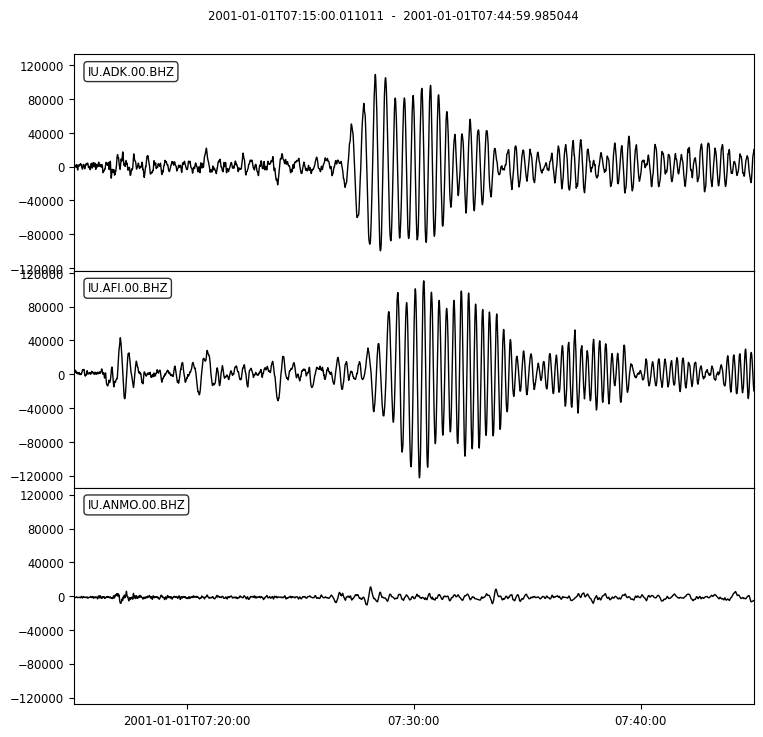

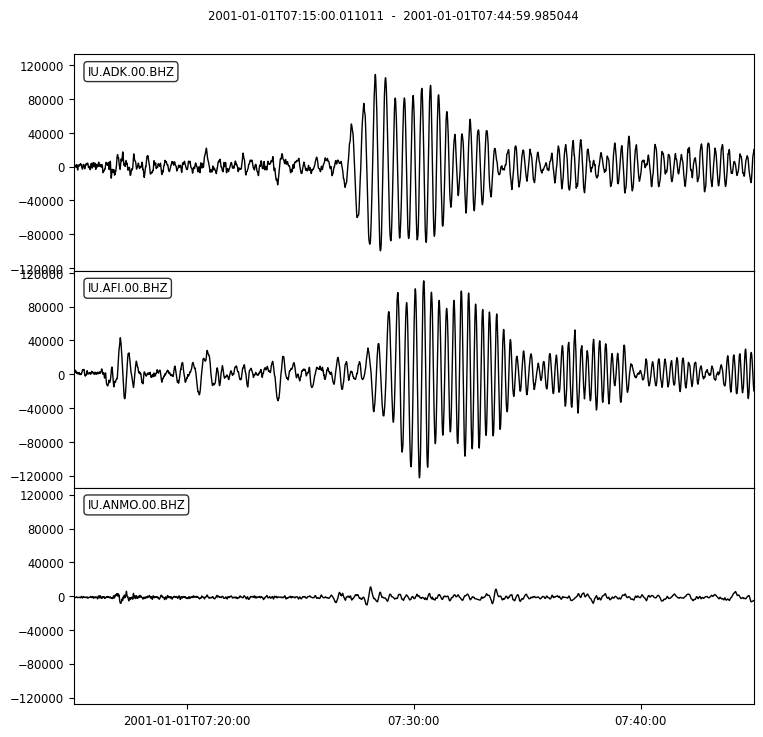

In [10]:
inventory.plot()

### Solar data

Satelite: https://science.nasa.gov/mission/ace/

Data source policy statement: https://izw1.caltech.edu/ACE/ASC/level2/policy_lvl2.html

#### Data import

In [19]:
# The first half of the dataset
data = cdas.get_data('AC_H1_MFI', ['Magnitude'],
                     '1998-02-01T00:00:00Z', '2010-01-01T00:00:00Z',
                     dataRepresentation = dr.XARRAY)[1]
print(data)

<xarray.Dataset> Size: 19MB
Dimensions:    (Epoch: 1566721)
Coordinates:
  * Epoch      (Epoch) datetime64[ns] 13MB 1998-02-01 ... 2010-01-01
Data variables:
    Magnitude  (Epoch) float32 6MB 9.344 9.44 9.186 10.01 ... 3.028 2.994 2.96
Attributes: (12/29)
    TITLE:                       ['ACE> Magnetometer Parameters']
    Project:                     ['ISTP>International Solar-Terrestrial Physi...
    Discipline:                  ['Space Physics>Interplanetary Studies']
    Source_name:                 ['AC>Advanced Composition Explorer']
    Data_type:                   ['H1>4-Min Level 2 Data']
    Descriptor:                  ['MAG>ACE Magnetic Field Instrument']
    ...                          ...
    Web_site:                    ['http://www.srl.caltech.edu/ACE/']
    Acknowledgement:             ['Please acknowledge the Principal', 'Invest...
    Rules_of_use:                ['See the rules of use available from the AC...
    Alt_logical_source:          ['ACE_MAG_Solar-Wind-

In [23]:
# The second half of the dataset
data2 = cdas.get_data('AC_H1_MFI', ['Magnitude'],
                     '2010-01-01T00:04:00Z', '2024-01-01T00:00:00Z',
                     dataRepresentation = dr.XARRAY)[1]
print(data2)

<xarray.Dataset> Size: 22MB
Dimensions:    (Epoch: 1840680)
Coordinates:
  * Epoch      (Epoch) datetime64[ns] 15MB 2010-01-01T00:04:00 ... 2024-01-01
Data variables:
    Magnitude  (Epoch) float32 7MB 2.939 3.114 3.088 3.084 ... 5.47 5.487 5.547
Attributes: (12/29)
    TITLE:                       ['ACE> Magnetometer Parameters']
    Project:                     ['ISTP>International Solar-Terrestrial Physi...
    Discipline:                  ['Space Physics>Interplanetary Studies']
    Source_name:                 ['AC>Advanced Composition Explorer']
    Data_type:                   ['H1>4-Min Level 2 Data']
    Descriptor:                  ['MAG>ACE Magnetic Field Instrument']
    ...                          ...
    Web_site:                    ['http://www.srl.caltech.edu/ACE/']
    Acknowledgement:             ['Please acknowledge the Principal', 'Invest...
    Rules_of_use:                ['See the rules of use available from the AC...
    Alt_logical_source:          ['ACE_MAG_S

In [32]:
# Join the two datasets
solar = pd.DataFrame({'Date': [*data.Epoch.values, *data2.Epoch.values], 'Magnitude': [*data.Magnitude.values, *data2.Magnitude.values]})
solar.to_parquet('Data/solar.parquet', index = False)
solar

,Date,Magnitude
0,1998-02-01 00:00:00,9.344
1,1998-02-01 00:04:00,9.440
2,1998-02-01 00:08:00,9.186
3,1998-02-01 00:12:00,10.007
4,1998-02-01 00:16:00,10.303
...,...,...
3407396,2023-12-31 23:44:00,5.532
3407397,2023-12-31 23:48:00,5.442
3407398,2023-12-31 23:52:00,5.470
3407399,2023-12-31 23:56:00,5.487


#### Data check

In [22]:
# Orignal data
data = pd.read_parquet('Data/solar.parquet')

# Savitzky-Golay smoothing with 1 hour window and 3rd degree polynomial
deterministic_component = sp.signal.savgol_filter(data['Magnitude'], 15, 2)

In [ ]:
# Plot original data
fig = go.Figure()
fig.add_trace(go.Scatter(x = data['Date'], y = data['Magnitude'], mode = 'lines', name = 'Original 4m data', hoverinfo = 'skip'))
fig.show()

In [ ]:
# EMD smoothing but it works very slow on such big datasets
imfs = fun.emd(data['Magnitude'], data['Date'])
imfs_p = fun.phase_spectrum(imfs)
mis = fun.phase_mi(imfs_p)
stochastic_component, deterministic_component = fun.divide_signal(data['Magnitude'], data['Date'], imfs, mis, cutoff = 0.05)
fig = go.Figure()
fig.add_trace(go.Scatter(x = data['Date'], y = deterministic_component, mode = 'lines', name = 'Original 4m data', hoverinfo = 'skip'))
fig.show()

In [ ]:
# Plot smoothed data
fig = go.Figure()
fig.add_trace(go.Scatter(x = data['Date'], y = deterministic_component, mode = 'lines', name = 'Original 4m data', hoverinfo = 'skip'))
fig.show()

In [27]:
# Check number of transitions for original and smoothed data
# Params for calculating critical transitions
ma = 1.2
mv = 1.05

# Calculating critical transitions in the time series
def find_rise(data, column, ma, mv, window):
    data_final = pd.DataFrame(data.index).set_index(0)
    data_final = data[column].to_frame().dropna()
    data_final[f'MA{window}'] = data_final[column].rolling(int(window)).mean()
    data_final[f'MV{window}'] = data_final[column].rolling(int(window)).var()
    data_final['Dynamics MA'] = data_final[f'MA{window}'] / data_final[f'MA{window}'].shift(5)
    data_final['Dynamics MV'] = data_final[f'MV{window}'] / data_final[f'MV{window}'].shift(5)
    data_final['Rise'] = (data_final['Dynamics MA'] >= ma) & (data_final['Dynamics MV'] >= mv)
    return data_final

def find_transitions(data_final, distance, tail):
    data_transitions = data_final[data_final['Rise'] == True]
    transitions = data_transitions.index
    final_transitions = []
    for i, index in enumerate(transitions):
        if i < len(transitions) - 1:
            if index - transitions[i - 1] > distance + tail:
                final_transitions.append(index)
    return data_transitions[data_transitions.index.isin(final_transitions)]

data_final = find_rise(data, 'Magnitude', ma, mv, 100)
print(len(data_final[data_final['Rise'] == True]))
find_transitions(data_final, distance, tail)

69


,Magnitude,MA100,MV100,Dynamics MA,Dynamics MV,Rise
419637,41.550999,9.31204,58.239213,1.203758,2.835985,True
479824,23.952000,6.75704,31.333405,1.210883,55.022725,True
501211,36.368999,8.96016,52.354275,1.203370,5.799523,True
1776161,30.229000,6.32403,31.545660,1.206100,4.490424,True
1788664,22.993999,1.91635,6.416056,1.258199,6.806076,True
1853806,37.636002,8.89081,49.233737,1.202603,9.193280,True
2086027,6.905000,1.65816,1.644680,1.207093,3.240982,True
2285879,4.568000,1.27997,0.884916,1.202290,52.859140,True
2427835,24.612000,5.51178,21.261232,1.215719,3.275581,True
2557883,19.749001,3.92133,11.713203,1.233270,74.087544,True


In [25]:
data_final = find_rise(pd.DataFrame({'Magnitude': deterministic_component}), 'Magnitude', ma, mv, 100)
print(len(data_final[data_final['Rise'] == True]))
find_transitions(data_final, distance, tail)

61


,Magnitude,MA100,MV100,Dynamics MA,Dynamics MV,Rise
501212,41.950146,9.305473,59.969188,1.202062,4.056877,True
1776163,30.929331,6.775672,38.225430,1.205694,2.952154,True
1788663,13.133533,1.811267,3.455244,1.239675,5.636260,True
2086028,7.431741,1.726899,1.879406,1.208954,2.929394,True
2285889,7.578544,1.773764,2.832683,1.203390,2.035536,True
2427834,22.692097,5.295865,16.558396,1.205112,3.860177,True
2557884,17.744883,4.020304,10.687123,1.202467,6.484984,True
3123667,17.446779,4.224885,15.992318,1.201134,2.062288,True
